# **5º Período Análise de Risco em Brasília com Redes Neurais para Grafos (GNNs)**

> Pedro Henrique Monteiro Nascimento
>
> 241011582
>
> nascimento.monteiro@aluno.unb.br
>
> **Tópico Escolhido**: Graph Neural Networks (GNNs)
>
> **Referência Principal**: Hamilton, William L. (2020). *Graph Representation Learning*.Morgan & Claypool.

***

## Fundamentos das GNNs

### O que são Grafos?

Formalmente, um grafo `G=(V,E)` é definido por um conjunto de **nós** `V` (vértices) e um conjunto de **arestas** `E` que conectam pares desses nós. As arestas podem ser não-direcionadas (como em uma amizade no Facebook) ou direcionadas (como seguir alguém no Twitter). Nesse projeto, modelamos as RAs de Brasília como um grafo não-direcionado, onde as arestas representam fronteiras geográficas.

Grafos são uma linguagem universal para descrever sistemas complexos, desde redes sociais e interações de proteínas até a estrutura de cidades.

### Predição em Nível de Nó

O Aprendizado de Máquina em grafos abrange diversas tarefas, como:
* **Classificação de Nós**: Prever um rótulo para um nó (ex: classificar um usuário como "bot" ou "humano").
* **Predição de Arestas**: Inferir a existência de uma aresta faltante (ex: recomendar um novo amigo).
* **Classificação de Grafos**: Atribuir um rótulo a um grafo inteiro (ex: classificar uma molécula como tóxica ou não).

Este projeto foca em uma variação da **Classificação de Nós**: a **Regressão sobre Nós**. Em vez de prever uma categoria discreta, prevemos um valor contínuo (o índice de risco) para cada nó (RA). A principal dificuldade dessa tarefa, que a diferencia do aprendizado de máquina tradicional, é que os dados **não são independentes e identicamente distribuídos (i.i.d.)**. A característica de um nó está intrinsecamente ligada à de seus vizinhos, violando a premissa fundamental de muitos algoritmos clássicos.

### Feature Engineering ao Aprendizado de Representação

Abordagens tradicionais para tarefas em grafos dependiam de *feature engineering* manual: calcular estatísticas como grau do nó, centralidade e coeficientes de `clustering` para usar como features em um classificador padrão. Este processo é trabalhoso e inflexível, pois as features são fixas e não se adaptam à tarefa específica.

As GNNs surgem da ideia de **aprendizado de representação** (*representation learning*). Em vez de criar features manualmente, o objetivo é aprender automaticamente uma representação vetorial de baixa dimensão (um *embedding*) para cada nó, que capture sua posição e contexto estrutural dentro do grafo. Uma GNN é, em essência, um `codificador (encoder)` poderoso que aprende essa representação de forma otimizada para uma tarefa final.

### Framework Encoder-Decoder

* **Encoder**: Uma GNN que mapeia cada nó `v` para um embedding `z_v`. Diferente de métodos de *shallow embedding* (que otimizam um vetor único por nó ), as GNNs calculam o embedding com base na estrutura do grafo e nas features dos nós, compartilhando pesos e permitindo generalização para nós não vistos (*inductive learning*).
* **Decoder**: Uma função que usa os embeddings aprendidos para realizar uma tarefa. Para a regressão de nós, o decoder é simplesmente uma camada linear que mapeia o embedding final para o valor de risco.

### Mecanismo de Transição

O coração de uma GNN é o seu processo iterativo, onde as representações dos nós são refinadas camada a camada. Após `k` camadas, a representação de um nó contém informação agregada de sua vizinhança de `k`-saltos (*k-hop neighborhood*).

Cada camada de uma GNN implementa o seguinte para cada nó `u`:

$$\mathbf{h}_u^{(k+1)} = \text{UPDATE}^{(k)} \left( \mathbf{h}_u^{(k)}, \text{AGGREGATE}^{(k)} \left( \{ \mathbf{h}_v^{(k)} : v \in \mathcal{N}(u) \} \right) \right)$$

* **`AGGREGATE`**: Uma função que coleta as representações (`h_v`) da vizinhança (`N(u)`) e as combina em uma única "mensagem". Esta função deve ser **invariante à permutação** (a ordem dos vizinhos não importa), como `SUM`, `MEAN` ou `MAX`.
* **`UPDATE`**: Uma função (geralmente uma rede neural) que combina a mensagem agregada com a representação anterior do próprio nó (`h_u`) para gerar sua nova representação.

Este mecanismo garante que a GNN respeite a estrutura do grafo e seja **equivariante à permutação**: se a ordem dos nós na matriz de adjacência for alterada, os embeddings de saída são permutados de forma correspondente, mas seus valores permanecem consistentes (fórmula traduzida do material bibliográfico).

## Rede Neural Convolucional para Grafos (GCN)

A GCN, utilizada por Kipf & Welling (2016), é uma implementação específica do paradigma de passagem de mensagens. A fórmula de uma camada GCN é:

$$H^{(k+1)} = \sigma \left( \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} H^{(k)} W^{(k)} \right)$$

Onde `Ã = A + I` é a matriz de adjacência com **auto-loops** adicionados (garantindo que o nó considere suas próprias features)  e `D` é a matriz de graus. Esta normalização simétrica (`D^(-1/2) * A * D^(-1/2)`) é crucial:
* Ela previne que nós de alto grau dominem a agregação.
* Mantém a escala dos vetores de features numericamente estável.
* É motivada pela teoria espectral de grafos.

No código apresentado, a camada `torch_geometric.nn.GCNConv` abstrai toda essa complexidade matemática, permitindo-nos construir a rede de forma modular.

## Aplicação


1.  **Modelagem e Dados**: Se é criado um objeto `Data` do PyTorch Geometric, que encapsula `x` (features sintéticas), `edge_index` (conectividade das RAs) e `y` (alvo de risco).
2.  **Arquitetura**: GCN usa duas camadas `GCNConv`. A primeira captura o contexto local (vizinhos diretos), e a segunda expande o "campo receptivo" de cada nó para os vizinhos dos vizinhos (2-hops), permitindo ao modelo aprender padrões mais complexos.
3.  **Treinamento**: Otimize o modelo para minimizar o **Erro Quadrático Médio (MSE)** entre o risco previsto e o risco real sintético. O otimizador Adam ajusta os pesos `W` das camadas `GCNConv` para aprender a mapear a estrutura e as features do grafo para o índice de risco.
4.  **Visualização**: O mapa de calor final visualiza as previsões do modelo, demonstrando sua capacidade de atribuir um índice de risco a cada RA com base não apenas em suas características isoladas, mas em seu papel dentro da "rede" de Brasília.


### Over-smoothing

* **Over-smoothing**: Uma das principais limitações das GNNs, á medida que as camadas são empilhadas, a passagem de mensagens repetida tende a fazer com que as representações de todos os nós em um componente conectado do grafo converjam para um único valor, sendo nao comparável. Isso ocorre porque o processo de agregação é análogo a um ***low-pass filter** que "suaviza" o sinal (features) ao longo do grafo. Na prática, isso limita a profundidade da maioria das GNNs a poucas camadas.
    * **Soluções**: Técnicas como *skip connections* (inspiradas em ResNets) , *gated updates* (inspiradas em LSTMs/GRUs)  e *jumping knowledge connections*  são usadas para combater esse problema, preservando informações de camadas anteriores (Material retirado de pesquisa e solução ainda não aplicada).

* **Teste de Weisfeiler-Lehman (WL)**: A capacidade de uma GNN de distinguir grafos estruturalmente diferentes é um limite fundamental. Foi provado que as GNNs baseadas em passagem de mensagens são, no máximo, **tão poderosas quanto o teste 1-WL** para isomorfismo de grafos. Isso significa que se o teste WL não consegue distinguir dois grafos, uma GCN também não conseguirá.
    * **k-GNNs**: A atividade atual explora arquiteturas como as **k-GNNs**, que operam em subgrafos de tamanho `k` em vez de nós individuais `i`, para alcançar o poder dos testes k-WL, embora com um custo computacional muito maior.

### Conclusão

Este trabalho visou construir uma GNN para um problema retirado de um hackathon da Campus Party 17 Brasília, em que a previsão de áreas de riscos afetadas pelos seus vizinhos possuia dificuldades significativas, mesmo que a presente atividade apresente dados mockados. A análise demonstrou que as GNNs fornecem um framework poderoso e teoricamente fundamentado para o aprendizado em dados relacionais, superando as limitações das abordagens tradicionais. As GNNs não são apenas uma ferramenta de engenharia; elas representam um avanço fundamental na capacidade da IA de entender e raciocinar sobre sistemas conectados. Apesar das limitações conhecidas e o limite de tempo imposto para a atividade, a atividade atual tenta explorar novas arquiteturas para ir além do campo básico e superficial de abordades das GNNs e a aplicada GCN.

---
### Referências

1.  5º Período PS 2025.1
2.  Hamilton, William L. (2020). *Graph Representation Learning*. Morgan & Claypool.




Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
objeto de dados criado:
Data(x=[35, 4], edge_index=[2, 104], y=[35], train_mask=[35], test_mask=[35])

modelo gcn definido:
GCN(
  (conv1): GCNConv(4, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=1, bias=True)
)

treinamento...
epoca: 020, perda treino: 4907.6304, perda teste: 4705.5596
epoca: 040, perda treino: 739.0659, perda teste: 121.0250
epoca: 060, perda treino: 90.7218, perda teste: 16.7858
epoca: 080, perda treino: 125.8310, perda teste: 14.6746
epoca: 100, perda treino: 147.3617, perda teste: 33.1617
epoca: 120, perda treino: 153.3627, perda teste: 8.2621
epoca: 140, perda treino: 82.6393, perda teste: 18.9983
epoca: 160, perda treino: 40.5890, perda teste: 11.7731
epoca: 180, perda treino: 106.4930, perda teste: 12.3222
epoca: 200, perda treino: 111.4048, perda teste: 13.5034

perda final (mse) no teste: 13.5034

comparacao dos resultados:
                         ra  risco_real 

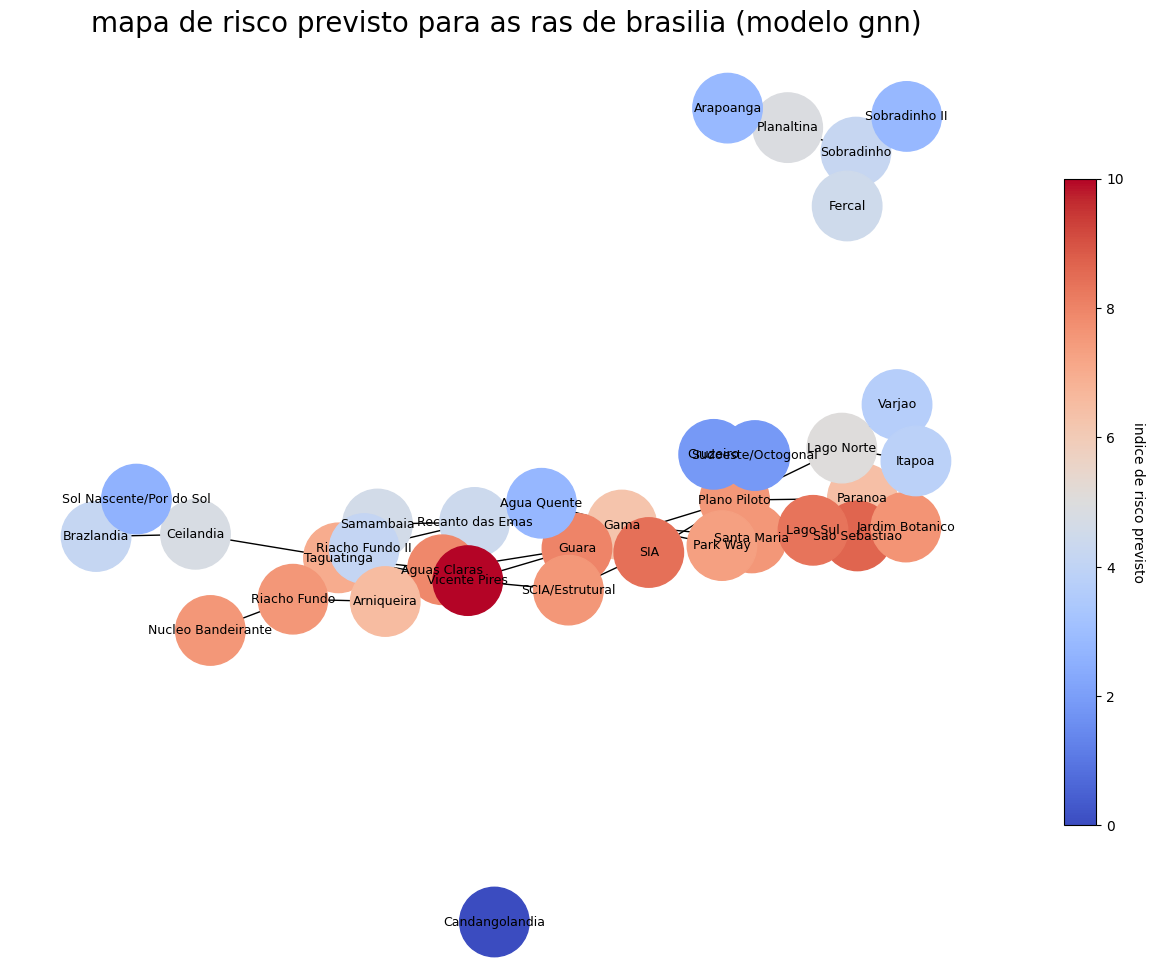

In [3]:
# instalando o pytorch geometric, que eh o principal pra gnn, o segundo eh manipulacao basica e pra plotar os graficos
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
!pip install networkx matplotlib pandas

import torch
import torch.nn.functional as F
from torch_geometric.data import Data

from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx

import networkx as nx
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# primeiro passo: montar o grafo de brasilia, os nos sao as regioes administrativas (RAs), as arestas (edges) significam que duas RAs fazem fronteira
# a lista de RAs foi retirada do site do GDF, como nao tem um arquivo oficial facil de achar com essas fronteiras, foi uma aproximacao visual.
ras_df = [
    "Plano Piloto", "Gama", "Taguatinga", "Brazlandia", "Sobradinho",
    "Planaltina", "Paranoa", "Nucleo Bandeirante", "Ceilandia", "Guara",
    "Cruzeiro", "Samambaia", "Santa Maria", "Sao Sebastiao", "Recanto das Emas",
    "Lago Sul", "Riacho Fundo", "Lago Norte", "Candangolandia", "Aguas Claras",
    "Riacho Fundo II", "Sudoeste/Octogonal", "Varjao", "Park Way", "SCIA/Estrutural",
    "Sobradinho II", "Jardim Botanico", "Itapoa", "SIA", "Vicente Pires",
    "Fercal", "Sol Nascente/Por do Sol", "Arniqueira", "Arapoanga", "Agua Quente"
]

# convert nome em numero
ra_map = {name: i for i, name in enumerate(ras_df)}
num_nodes = len(ras_df)

# definindo os vizinhos
edges = [
    ("Plano Piloto", "Cruzeiro"), ("Plano Piloto", "Sudoeste/Octogonal"), ("Plano Piloto", "Lago Sul"),
    ("Plano Piloto", "Lago Norte"), ("Plano Piloto", "Guara"), ("Plano Piloto", "SIA"), ("Plano Piloto", "Paranoa"),
    ("Taguatinga", "Ceilandia"), ("Taguatinga", "Samambaia"), ("Taguatinga", "Aguas Claras"), ("Taguatinga", "Vicente Pires"),
    ("Ceilandia", "Sol Nascente/Por do Sol"), ("Ceilandia", "Brazlandia"), ("Ceilandia", "Taguatinga"),
    ("Samambaia", "Recanto das Emas"), ("Samambaia", "Taguatinga"), ("Samambaia", "Riacho Fundo II"),
    ("Gama", "Santa Maria"), ("Gama", "Recanto das Emas"), ("Gama", "Park Way"),
    ("Sobradinho", "Sobradinho II"), ("Sobradinho", "Planaltina"), ("Sobradinho", "Fercal"),
    ("Planaltina", "Arapoanga"), ("Planaltina", "Sobradinho"),
    ("Lago Sul", "Park Way"), ("Lago Sul", "Jardim Botanico"), ("Lago Sul", "Sao Sebastiao"),
    ("Lago Norte", "Varjao"), ("Lago Norte", "Itapoa"),
    ("Guara", "Aguas Claras"), ("Guara", "Vicente Pires"), ("Guara", "SIA"),
    ("Aguas Claras", "Arniqueira"), ("Aguas Claras", "Vicente Pires"),
    ("Santa Maria", "Sao Sebastiao"), ("Santa Maria", "Park Way"),
    ("Recanto das Emas", "Riacho Fundo II"), ("Recanto das Emas", "Gama"),
    ("Paranoa", "Itapoa"), ("Paranoa", "Jardim Botanico"), ("Paranoa", "Sao Sebastiao"),
    ("Riacho Fundo", "Riacho Fundo II"), ("Riacho Fundo", "Nucleo Bandeirante"), ("Riacho Fundo", "Arniqueira"),
    ("Sudoeste/Octogonal", "Cruzeiro"),
    ("SCIA/Estrutural", "SIA"), ("SCIA/Estrutural", "Vicente Pires"),
    ("Jardim Botanico", "Sao Sebastiao"),
    ("Vicente Pires", "Arniqueira"),
    ("Agua Quente", "Recanto das Emas"), ("Agua Quente", "Gama")
]

# convertendo a lista de nomes pra uma lista de indices numericos
edge_index_list = []
for u, v in edges:
    edge_index_list.append([ra_map[u], ra_map[v]])
    edge_index_list.append([ra_map[v], ra_map[u]]) # grafo nao-direcionado tem que reintroduzir o mapa

edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

# segundo passo: criar os dados, pra cada RA ter umas caracteristicas e um indice de risco mockados para previsao
np.random.seed(42)

num_features = 4 # densidade pop, renda media, densidade comercial, presenca policial
node_features = np.random.rand(num_nodes, num_features) * np.array([10000, 5000, 0.8, 10])
node_features = torch.tensor(node_features, dtype=torch.float)

# o risco vai ser baseado nessas features, mais pop, menos renda, etc -> maior risco
weights = torch.tensor([0.4, -0.3, 0.2, -0.5])
base_risk = node_features @ weights + torch.randn(num_nodes) * 2

# o risco de um lugar influenciado pelos vizinhos
y = torch.zeros(num_nodes)
for i in range(num_nodes):
    neighbors = edge_index[1, edge_index[0] == i]
    if len(neighbors) > 0:
        y[i] = 0.7 * base_risk[i] + 0.3 * torch.mean(base_risk[neighbors]) # 70% do risco proprio, 30% dos vizinhos
    else:
        y[i] = base_risk[i]


y = 10 * (y - y.min()) / (y.max() - y.min())
data = Data(x=node_features, edge_index=edge_index, y=y)
perm = torch.randperm(num_nodes)
train_size = int(0.7 * num_nodes)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[perm[:train_size]] = True
data.test_mask[perm[train_size:]] = True

print("objeto de dados criado:")
print(data)

# terceiro passo: definir a GCN (Graph Convolutional Network) com duas camadas
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        # camadas da gnn que aprendem a vizinhanca
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # camada de saida que vai dar o resultado final (o risco)
        self.out = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.out(x)
        return x.squeeze()

model = GCN(num_node_features=num_features, hidden_channels=16)
print("\nmodelo gcn definido:")
print(model)


optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.MSELoss() # erro quadratico medio, padrao pra regressao

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.test_mask], data.y[data.test_mask])
    return loss.item(), out

print("\ntreinamento...")
for epoch in range(1, 201):
    train_loss = train()
    if epoch % 20 == 0:
        test_loss, _ = test()
        print(f'epoca: {epoch:03d}, perda treino: {train_loss:.4f}, perda teste: {test_loss:.4f}')

# quinto passo: ver os resultados e plotar o mapa de risco
final_test_loss, final_predictions = test()
print(f"\nperda final (mse) no teste: {final_test_loss:.4f}")

results_df = pd.DataFrame({
    'ra': ras_df,
    'risco_real': data.y.detach().numpy(),
    'risco_previsto': final_predictions.detach().numpy(),
    'tipo': ['treino' if mask else 'teste' for mask in data.train_mask]
})

print("\ncomparacao dos resultados:")
print(results_df.round(2))
fig, ax = plt.subplots(figsize=(16, 12))
g = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(g, seed=42)

node_colors = final_predictions.detach().numpy()
vmin = data.y.min()
vmax = data.y.max()

nx.draw(g, pos, ax=ax, labels={i: name for i, name in enumerate(ras_df)},
        with_labels=True, node_color=node_colors, cmap='coolwarm',
        node_size=2500, font_size=9, font_color='black')

sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('indice de risco previsto', rotation=270, labelpad=15)

ax.set_title('mapa de risco previsto para as ras de brasilia (modelo gnn)', size=20)
plt.show()
